### **Introduction**

The Walaris dataset contains files with information on the trajectory of flying objects. The objects are tracked using a stationary camera operating in the visible or near IR ranges. The main information provided is the direction of the object relative to the camera, represented by a unit vector in x-y-z. The absolute size of the vector is always one. The three vector components can be coverted into two independent angles of azimuth and elevation.

**Insights and limitations derived from the nature of the data** \


*   Since we are only provided the direction of the object and no range, the problem has no scale. This means that we cannot calculate absolute distances, volume covered, velocity, etc.
*   An object flying high and fast in a straight line would look exactly like an object flying lower and proportionally slower.
*   While we could try to use the changes in direction as a property of the object, it is just as tricky to use the **size** of the change as a feature. The angular velocity size will also scale with the range of the object.
* Edge case: an object flying at very high elevation (almost above the camera) may provide an indication of the range. The change in the elevation for such a trajectory is expected to be the fastest and of course scales with the distance. If we know the expected heights and speeds of objects, we can perhaps use this to set some hard limits. For example, a UAV or bird can fly quite low and cause a fast change in elevtion. An airplane is not expected to fly low enough, such that its speed can produce the same change in elevation. However, this is an edge case...
* An object flying directly away from the camera takes up a very small span of azimuth angle. If it is far away, the elevation would also change very little. This scenario needs to be differentiable from a static object.
* The problem should be completely symmetric in the azimuth parameter, since there is no meaning to the direction of flying in the XY plane. We can use this fact in two ways. One would be normalize all trajectories to start from 0 angle for example. The other would be be to augment new samples by offsetting the azimuth angle.
* Another form of augmentation would be flipping x and y. This is equivalent to negating the azimuth angle.
* Elevation should be treate more carefully. Most objects basically maintain their height for energy considerations. This should be reflected in the elevation-over-time behavior. Offsetting the elevation by a constant would for example make a constant height trajectory not constant anymore, but get higher as the object moves away.
* Due to the nature of the data, it is difficult to extract features that have meaning by their size. The focus in such a direction should probaly be on ratios or correlations between object properties.

**Time sampling related notes:**
* The frequency of the sampling may vary, but it is in general close to 25 Hz (sample each 40 msec).
* The duration of samples ranges from 0.9 sec to 300 sec
* There are sometimes time gaps in the data. For most applications, a sort of interpolation is good practice to compensate. Otherwise, the time must be an inherent part of the model.

### Distribution of classes

There are 5 classes of objects:
* UAV - 21 samples
* Bird - 13 samples
* Airplane - 127 samples
* Helicopter - 5 samples
* Static Object - 67 samples

The representation of the classes is not balanced.\
In the airplane class there are files taken from a VIS range camera and NIR range camera.



### Imports and loading

In [ ]:
# imports

import io
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.interpolate import interp1d

# Machine Learning
from sklearn.decomposition import PCA

# prompt: Access a folder on google drive and import the data locally
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


### raw data

In [ ]:
def convert_to_angles(xx, yy, zz, ang = 'deg'):
    theta = np.arctan2(yy, xx)
    phi = np.arcsin(zz)
    if ang == 'deg':
        theta = np.rad2deg(theta)
        phi = np.rad2deg(phi)
    return theta, phi

In [ ]:
def raw_angles_data_from_json(file_path):
    with open(file_path) as f:
        data = json.load(f)

    tt = []
    xx = []
    yy = []
    zz = []
    size_hor = []
    size_ver = []
    light_domain = data['light_domain']

    for r in data['track_data']:
      tt.append(r['timestamp'])
      xx.append(r['position_xyz'][0])
      yy.append(r['position_xyz'][1])
      zz.append(r['position_xyz'][2])
      size_hor.append(r['angular_size_hor_ver'][0])
      size_ver.append(r['angular_size_hor_ver'][1])


    tt = np.array(tt).astype(float)
    tt = tt-tt[0]
    xx = np.array(xx)
    yy = np.array(yy)
    zz = np.array(zz)
    theta, phi = convert_to_angles(xx, yy, zz)
    size_hor = np.array(size_hor).astype(float)
    size_ver = np.array(size_ver).astype(float)

    return tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain

In [ ]:
def local_std(data, window = 10):
  """
  This function returns the typical local standard deviation of an array for the purpose:
  1. Finding outliers
  2. Indicating the scale of the sample
  It calculates the standard deviation on a rolling window and returns the median of all standard deviations.
  """
  data = pd.Series(data)
  rolling_std = data.rolling(window).std()
  return rolling_std.median()

In [ ]:
def extract_statistics_from_file(file_path, visualize):
    tt, xx, yy, zz, theta, phi, size_hor, size_ver, light_domain = raw_angles_data_from_json(file_path)

# time
    sample_duration = tt[-1]-tt[0]
    num_samples = len(tt)
    time_gaps = np.diff(tt)
    max_time_gap = np.max(time_gaps)
    min_time_gap = np.min(time_gaps)
    median_time_gap = np.median(time_gaps)
# sizes (no real scale...)
    max_elevation = phi.max()
    min_elevation = phi.min()
    max_azimuth = theta.max()
    min_azimuth = theta.min()
    max_size_hor = size_hor.max()
    max_size_ver = size_ver.max()
    theta_std = local_std(theta)
    phi_std = local_std(phi)

    return sample_duration, num_samples, max_time_gap, min_time_gap, median_time_gap, max_elevation, min_elevation, max_azimuth, min_azimuth, max_size_hor, max_size_ver, light_domain, theta_std, phi_std


In [ ]:
# go through the subfolders under Flight Track, run the function extract_feature_from_file on all files in all the subfolders and save outputs in a pandas dataframe

subfolders = os.listdir('track_data')
features = []
for subfolder in subfolders:
    files = os.listdir('track_data/' + subfolder)
    for file in files:
        if file.endswith('.json'):
            file_path = 'track_data/' + subfolder + '/' + file
            sample_duration, num_samples, max_time_gap, min_time_gap, median_time_gap, max_elevation, min_elevation, max_azimuth, min_azimuth, max_size_hor, max_size_ver, light_domain, theta_std, phi_std = extract_statistics_from_file(file_path, False)
            features.append([subfolder, file, sample_duration, num_samples, max_time_gap, min_time_gap, median_time_gap, max_elevation, min_elevation, max_azimuth, min_azimuth, max_size_hor, max_size_ver, light_domain, theta_std, phi_std])

features_df = pd.DataFrame(features, columns=['label', 'file', 'sample_duration', 'num_samples', 'max_time_gap',
                                              'min_time_gap', 'median_time_gap', 'max_elevation', 'min_elevation', 'max_azimuth', 'min_azimuth',
                                              'max_size_hor', 'max_size_ver', 'light_domain', 'theta_std', 'phi_std'])


In [ ]:
features_df['azimuth_angle'] = features_df['max_azimuth'] - features_df['min_azimuth']
features_df['elevation_angle'] = features_df['max_elevation'] - features_df['min_elevation']

In [ ]:
features_df.head()

,label,file,sample_duration,num_samples,max_time_gap,min_time_gap,median_time_gap,max_elevation,min_elevation,max_azimuth,min_azimuth,max_size_hor,max_size_ver,light_domain,theta_std,phi_std,azimuth_angle,elevation_angle
0,airplane,VIS_airplane_20230601-256_20230601-145241.json,33.598361,789,1.679963,0.033025,0.039965,35.215613,29.543039,54.788491,27.346175,0.162523,0.097700,VIS,0.099139,0.021762,27.442316,5.672574
1,airplane,VIS_airplane_20230605-361_20230605-141153.json,38.957139,762,0.280628,0.005609,0.044160,14.080438,10.688113,-74.452404,-90.325480,0.250030,0.111124,VIS,0.060075,0.014618,15.873076,3.392325
2,airplane,VIS_airplane_20230602-3310_20230602-181049.json,11.560458,286,0.160266,0.038048,0.039991,48.795570,43.080466,22.492135,10.244972,0.218673,0.130753,VIS,0.128401,0.060989,12.247163,5.715104
3,airplane,NIR_airplane_20231025-2728_20231025-005440.json,31.608484,721,0.841433,0.000000,0.040008,30.943570,13.886329,144.310227,50.766450,3.527934,1.763967,NIR,0.400207,0.114617,93.543777,17.057241
4,airplane,VIS_airplane_20231023-4970_20231023-155314.json,140.581685,3405,0.721091,0.010819,0.039997,26.231047,17.588327,156.385999,79.103851,1.187738,1.331967,VIS,0.036383,0.049544,77.282147,8.642720


###Statistics

In [ ]:
features_df.describe()

,sample_duration,num_samples,max_time_gap,min_time_gap,median_time_gap,max_elevation,min_elevation,max_azimuth,min_azimuth,max_size_hor,max_size_ver,theta_std,phi_std,azimuth_angle,elevation_angle
count,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000
mean,55.896975,1207.167300,0.471047,0.023973,0.043520,18.611919,9.434402,-19.520025,-42.594421,1.093786,0.565300,0.094327,0.041296,23.074396,9.177517
std,52.464156,1179.311272,0.418731,0.010198,0.008911,20.292502,11.120808,92.419053,81.041857,1.619879,0.725917,0.244542,0.074637,53.982595,16.556878
min,0.918843,17.000000,0.042870,0.000000,0.039924,-10.962994,-30.672631,-153.819922,-179.979454,0.025297,0.014302,0.002361,0.001238,0.060639,0.032489
25%,28.239334,502.750000,0.125984,0.019195,0.040002,4.553577,3.274234,-82.118516,-88.647608,0.370310,0.216199,0.011525,0.011475,0.537960,0.427070
50%,34.315954,785.500000,0.320110,0.026877,0.040214,10.790158,7.766063,-74.691727,-77.259191,0.590628,0.305225,0.025871,0.018742,2.563601,1.595159
75%,67.371806,1437.250000,0.721039,0.031749,0.042385,27.009524,13.586023,12.678274,9.883192,1.464906,0.809506,0.073004,0.033101,20.931856,8.560587
max,300.130257,7503.000000,1.919657,0.039808,0.080622,87.075663,69.970195,179.999263,167.804680,16.857355,6.804535,4.196226,0.716915,359.963620,92.399362


In [ ]:
print(f'Maximal sample duration is {features_df.sample_duration.max():.2f} seconds')
print(f'Minimal sample duration is {features_df.sample_duration.min():.2f} seconds')
print(f'Maximal time gap is {features_df.max_time_gap.max():.2f} seconds')
print(f'Typical period is {1000*features_df.median_time_gap.mean():.2f} msec')

Maximal sample duration is 300.13 seconds
Minimal sample duration is 0.92 seconds
Maximal time gap is 1.92 seconds
Typical period is 43.52 msec


In [ ]:
colors = {'bird': 'green', 'airplane' : 'blue', 'uav' : 'orange', 'static-object': 'purple'}

#### Class Distribution

In [ ]:
features_df.groupby('label')['label'].count()

label
airplane         129
bird              36
static-object    308
uav               53
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

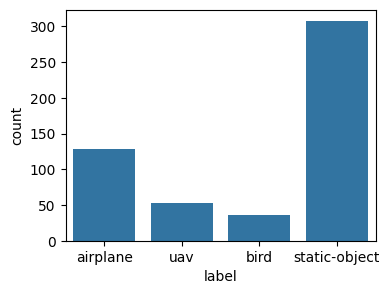

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))
# sns.countplot(x="label", data=features_df)
# sns.countplot(x="label", data=features_df)
sns.countplot(x="label", data=features_df)

####Time

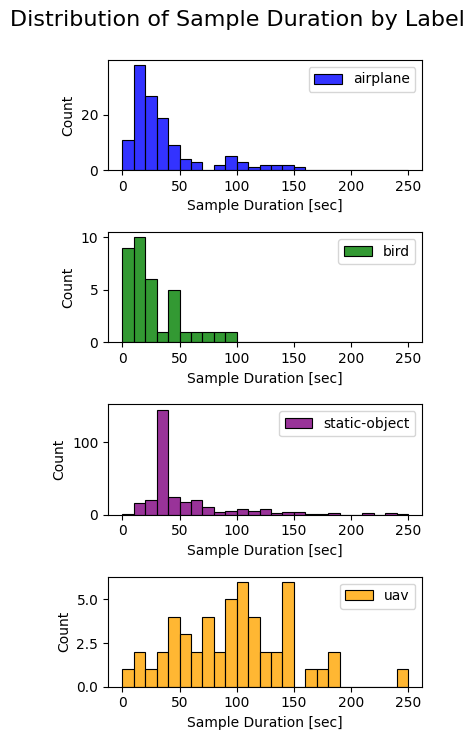

In [ ]:
# Group rows by label
features_df_grouped = features_df.groupby('label')

# Create a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(4, 7))

# Plot the distribution of sample_duration for each group
for i, (subfolder, group) in enumerate(features_df_grouped):
  # print(i, subfolder)
  sns.histplot(group['sample_duration'], binwidth=10, binrange=[0,250], color = colors[subfolder],ax=axes[i], label=subfolder, alpha=0.8)
  axes[i].set_xlabel('Sample Duration [sec]')
  axes[i].legend()

fig.tight_layout()
plt.suptitle('Distribution of Sample Duration by Label', y = 1.05, fontsize=16)
plt.show()

#### Elevation distribution by label

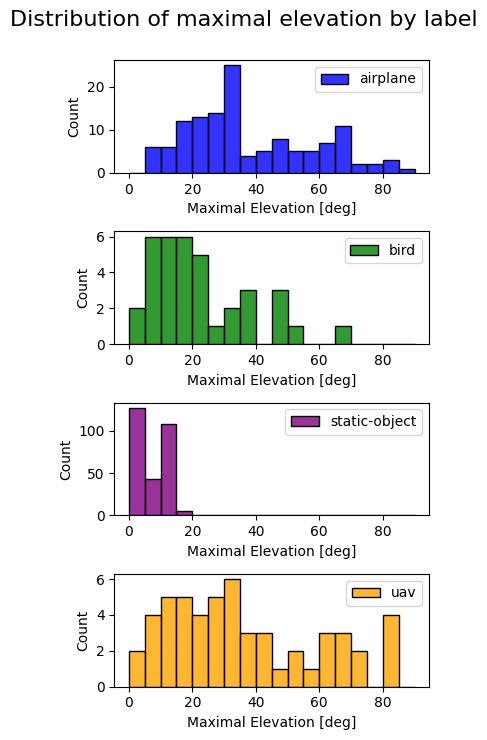

In [ ]:
# Group rows by label
features_df_grouped = features_df.groupby('label')

# Create a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(4, 7))

# Plot the distribution of maximal elevation for each group
for i, (subfolder, group) in enumerate(features_df_grouped):
  # print(i, subfolder)
  sns.histplot(group['max_elevation'], binwidth=5, binrange=[0,90], color = colors[subfolder],ax=axes[i], label=subfolder, alpha=0.8)
  axes[i].set_xlabel('Maximal Elevation [deg]')
  axes[i].legend()

fig.tight_layout()
plt.suptitle('Distribution of maximal elevation by label', y = 1.05, fontsize=16)
plt.show()

We learn from this that the UAV trajectories in the database tend to have higher elevation. It is plausible that this is because they are operated from the same location as the camera, and therefore have a section very close to the camera (almost above it).

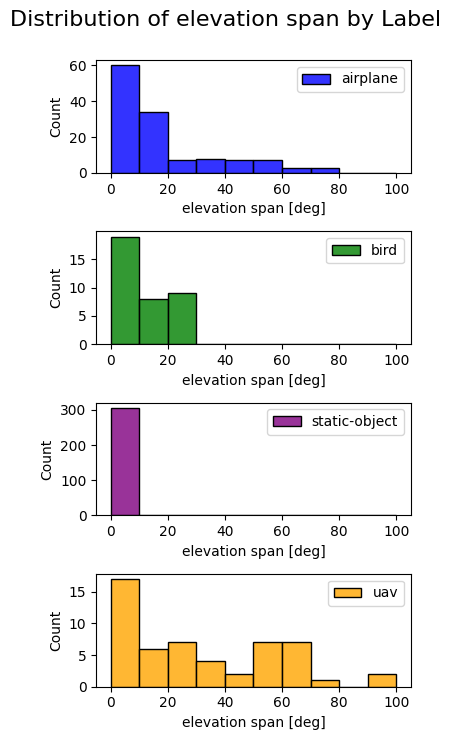

In [ ]:
# Group rows by label
features_df_grouped = features_df.groupby('label')

# Create a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(4, 7))

# Plot the distribution of sample_duration for each group
for i, (subfolder, group) in enumerate(features_df_grouped):
  # print(i, subfolder)
  sns.histplot(group['elevation_angle'], binwidth=10, binrange=[0,100], color = colors[subfolder],ax=axes[i], label=subfolder, alpha=0.8)
  axes[i].set_xlabel('elevation span [deg]')
  axes[i].legend()

fig.tight_layout()
plt.suptitle('Distribution of elevation span by Label', y = 1.05, fontsize=16)
plt.show()

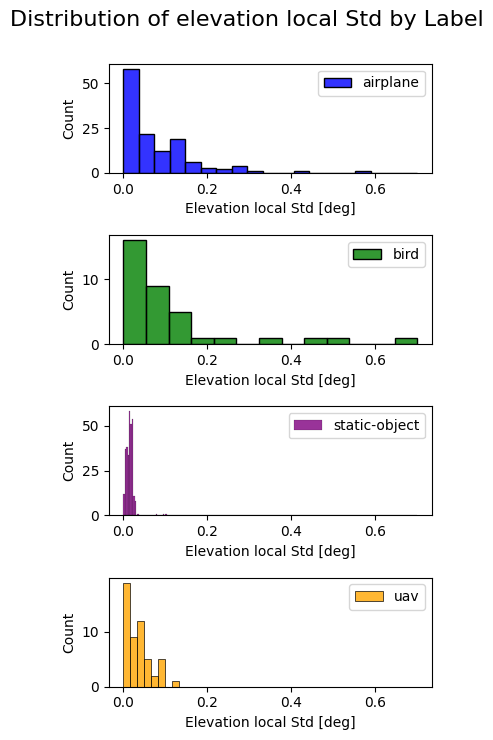

In [ ]:
# Group rows by label
features_df_grouped = features_df.groupby('label')

# Create a figure with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(4, 7))

# Plot the distribution of sample_duration for each group
for i, (subfolder, group) in enumerate(features_df_grouped):
  # print(i, subfolder)
  sns.histplot(group['phi_std'], binrange=[0,0.7], color = colors[subfolder],ax=axes[i], label=subfolder, alpha=0.8)
  axes[i].set_xlabel('Elevation local Std [deg]')
  axes[i].legend()

fig.tight_layout()
plt.suptitle('Distribution of elevation local Std by Label', y = 1.05, fontsize=16)
plt.show()